In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss, accuracy_score
from sklearn.utils.extmath import squared_norm
from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise
import numpy as np
import optuna, sklearn, sklearn.datasets
from fair_models import coefficient_of_variation, MOOLogisticRegression, FindCLogisticRegression, FindCCLogisticRegression
from fair_models import calc_reweight
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting

import plotly.graph_objects as go

import sys
sys.path.append("./MMFP/")
from MMPF.MinimaxParetoFair.MMPF_trainer import SKLearn_Weighted_LLR, APSTAR

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.



In [2]:
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [4]:
def dominate(a, b):
    sense = np.array([1, 1, 1, 1])
    if all((sense*a)>=(sense*b)) and any((sense*a)>(sense*b)):
        return 1
    else:
        return 0

In [5]:
def all_metrics_parallel_coord(dataset, metric = 'accuracy',
                               acc_min = None, acc_max = None,
                               eo_min = None, eo_max = None,
                               pp_min=None, pp_max = None,
                               cv_min = None, cv_max = None):
    
    dominate_metr = np.array([any([dominate(other, row)
                                   for other in dataset.values])
                              for row in dataset.values])
    
    metrics = ['accuracy', 'equal_opportunity', 'p_percent', 'c_variation']
    
    met_aux = {"Modelo": [],
              "Acurácia": [],
              "Igualdade de Oportunidade": [],
              "P porcento": [],
              "Coeficiente de variação": [],
              'model_id': [],
              "metric_id": [],
              "metric": []}

    for m in range(len(metrics)):
        metric = metrics[m]
        
        met_aux["Modelo"].extend(['RegLogistica', 'EqualOp', 'ParDemo', 'Reweight', 'MinMax', 'ErroMO', 'ProbMO'])
        met_aux["Acurácia"].extend([dataset.loc[('LogReg',metric),metrics[0]],
                          dataset.loc[('RegEqual',metric),metrics[0]],
                          dataset.loc[('RegDemo',metric),metrics[0]],
                          dataset.loc[('RegRewe',metric),metrics[0]],
                          dataset.loc[('Minimax',metric),metrics[0]],
                          dataset.loc[('RegMoo',metric),metrics[0]],
                          dataset.loc[('RegEqMoo',metric),metrics[0]]])
        met_aux["Igualdade de Oportunidade"].extend([dataset.loc[('LogReg',metric),metrics[1]],
                          dataset.loc[('RegEqual',metric),metrics[1]],
                          dataset.loc[('RegDemo',metric),metrics[1]],
                          dataset.loc[('RegRewe',metric),metrics[1]],
                          dataset.loc[('Minimax',metric),metrics[1]],
                          dataset.loc[('RegMoo',metric),metrics[1]],
                          dataset.loc[('RegEqMoo',metric),metrics[1]]])
        met_aux["P porcento"].extend([dataset.loc[('LogReg',metric),metrics[2]],
                          dataset.loc[('RegEqual',metric),metrics[2]],
                          dataset.loc[('RegDemo',metric),metrics[2]],
                          dataset.loc[('RegRewe',metric),metrics[2]],
                          dataset.loc[('Minimax',metric),metrics[2]],
                          dataset.loc[('RegMoo',metric),metrics[2]],
                          dataset.loc[('RegEqMoo',metric),metrics[2]]])
        met_aux["Coeficiente de variação"].extend([dataset.loc[('LogReg',metric),metrics[3]],
                          dataset.loc[('RegEqual',metric),metrics[3]],
                          dataset.loc[('RegDemo',metric),metrics[3]],
                          dataset.loc[('RegRewe',metric),metrics[3]],
                          dataset.loc[('Minimax',metric),metrics[3]],
                          dataset.loc[('RegMoo',metric),metrics[3]],
                          dataset.loc[('RegEqMoo',metric),metrics[3]]])
        met_aux['model_id'].extend([0,1,2,3,4,5,6])
        met_aux['metric_id'].extend([m,m,m,m,m,m,m])
        met_aux['metric'].extend([metric,metric,metric,metric,metric,metric,metric])

    m_metrics = pd.DataFrame(data=met_aux, 
                                columns=['Modelo','Acurácia','Igualdade de Oportunidade','P porcento',
                                         'Coeficiente de variação','model_id', 'metric_id', 'metric'])
    
    acc_min = acc_min if acc_min is not None else m_metrics['Acurácia'].min()
    acc_max = acc_max if acc_max is not None else m_metrics['Acurácia'].max()
    eo_min = eo_min if eo_min is not None else m_metrics['Igualdade de Oportunidade'].min()
    eo_max = eo_max if eo_max is not None else m_metrics['Igualdade de Oportunidade'].max()
    pp_min = pp_min if pp_min is not None else m_metrics['P porcento'].min()
    pp_max = pp_max if pp_max is not None else m_metrics['P porcento'].max()
    cv_min = cv_min if cv_min is not None else m_metrics['Coeficiente de variação'].min()
    cv_max = cv_max if cv_max is not None else m_metrics['Coeficiente de variação'].max()

    fig = go.FigureWidget(data=
        go.Parcoords(
            line = dict(color = m_metrics['model_id'], 
                        colorscale = [(0.0, colors[0]),(0.14, colors[0]),
                            (0.14, colors[1]), (0.28, colors[1]),
                            (0.28, colors[2]),(0.42, colors[2]),
                            (0.42, colors[3]),(0.56, colors[3]),
                            (0.56, colors[4]),(0.7, colors[4]),
                            (0.7, colors[5]),(0.84, colors[5]),
                            (0.84, colors[6]),(1.0, colors[6])], 
                        showscale = True, cmin = 0, cmax = 6,
                       colorbar = {'tickvals': m_metrics['model_id'].tolist(),
                              'ticktext': m_metrics['Modelo'].tolist(),
                                  'title': 'Modelo'}),
            dimensions = list([
                dict(tickvals = [0,1,2,3],
                     ticktext = ['Acurácia','Iguald Oport','P porcento',
                                         'Coef de var'],
                     label = 'Métrica otimizada', values = m_metrics['metric_id']),
                #dict(tickvals = [0,1,2,3,4,5,6],
                #     ticktext = ['LogReg', 'RegEqual', 'RegDemo', 'RegRewe', 'Minimax','RegMoo', 'RegEqMoo'],
                #     label = 'Modelo', values = m_metrics['model_id']),
                dict(range = [acc_min, acc_max],
                    label = 'Acurácia', values = m_metrics['Acurácia']),
                dict(range = [eo_min, eo_max],
                    label = 'Igualdade de Oportunidade', values = m_metrics['Igualdade de Oportunidade']),
                dict(range = [pp_min, pp_max],
                    label = 'P porcento', values = m_metrics['P porcento']),
                dict(range = [cv_min, cv_max],
                    label = 'Coeficiente de variação', values = m_metrics['Coeficiente de variação']),
            ])
        ), layout = dict(height=400)#title = "Resultado para cada modelo - German")
    )
    
    def selection_handler(trace, points, selector):
        print(points, selection)

    fig.data[0].on_selection(selection_handler)
    
    
    fig.update_layout(
        plot_bgcolor = 'white',
        paper_bgcolor = 'white'
    )

    return fig

## Dataset

In [17]:
data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
fair_feature = "not_white"
pred_feature = "Two_yr_Recidivism"

In [18]:
X = data.drop([pred_feature], axis=1)
y = data[pred_feature]


X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=100)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=100)

## Fair Moo

In [19]:
moo_err = monise(weightedScalar=FairScalarization(X_train, y_train, fair_feature),
                 singleScalar=FairScalarization(X_train, y_train, fair_feature),
                  nodeTimeLimit=2, targetSize=150,
                  targetGap=0, nodeGap=0.05, norm=False)

moo_err.optimize()

2021-03-07 21:52:13,429 - moopt.monise - DEBUG: Finding 1th individual minima
2021-03-07 21:52:13,532 - moopt.monise - DEBUG: Finding 2th individual minima
2021-03-07 21:52:13,599 - moopt.monise - DEBUG: Finding 3th individual minima
2021-03-07 21:52:13,671 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2021-03-07 21:52:13,773 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-03-07 21:52:13,884 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-03-07 21:52:14,012 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-03-07 21:52:14,138 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-03-07 21:52:14,314 - moopt.monise - DEBUG: 9th solution - importance: 0.5224254433656503
2021-03-07 21:52:14,439 - moopt.monise - DEBUG: 10th solution - importance: 0.34172446693567604
2021-03-07 21:52:14,602 - moopt.monise - DEBUG: 11th solution - importance: 0.33906037100409236
2021-03-07 21:52:14,780 - moopt.monise - DEBUG: 12th solution - importance: 0.1522336

2021-03-07 21:52:46,312 - moopt.monise - DEBUG: 87th solution - importance: 0.0009057722615395132
2021-03-07 21:52:47,283 - moopt.monise - DEBUG: 88th solution - importance: 0.0008849500133889662
2021-03-07 21:52:48,250 - moopt.monise - DEBUG: 89th solution - importance: 0.0007765418995419189
2021-03-07 21:52:49,295 - moopt.monise - DEBUG: 90th solution - importance: 0.0007472213226360129
2021-03-07 21:52:50,279 - moopt.monise - DEBUG: 91th solution - importance: 0.0007385829947833094
2021-03-07 21:52:51,239 - moopt.monise - DEBUG: 92th solution - importance: 0.0006873127193065609
2021-03-07 21:52:52,269 - moopt.monise - DEBUG: 93th solution - importance: 0.0006829070262516504
2021-03-07 21:52:53,372 - moopt.monise - DEBUG: 94th solution - importance: 0.0006558203229247273
2021-03-07 21:52:54,399 - moopt.monise - DEBUG: 95th solution - importance: 0.0006290642105369375
2021-03-07 21:52:55,580 - moopt.monise - DEBUG: 96th solution - importance: 0.0005960339986452179
2021-03-07 21:52:56,

In [20]:
m_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}
sols = []

for solution in moo_err.solutionsList:
    sols.append(solution.x)
    m_aux["Acurácia"].append(solution.x.score(X_val, y_val))
    m_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x,
                                                                                                            X_val, y_val))
    m_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_val))
    m_aux["Coeficiente de variação"].append(coefficient_of_variation(solution.x, X_val, y_val))

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars



In [21]:
m_metrics = pd.DataFrame(data=m_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [22]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color='#e31a1c',
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = m_metrics['Acurácia']),
            dict(range = [0,1],
                label = 'IO', values = m_metrics['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P%', values = m_metrics['P porcento']),
            dict(range = [1,0.3],
                label = 'CV', values = m_metrics['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

In [ ]:
def calc_res(model__):
    return [accuracy_score(y_test, model__.predict(X_test)),
            equal_opportunity_score(sensitive_column=fair_feature)(model__, X_test, y_test),
            p_percent_score(sensitive_column=fair_feature)(model__, X_test),
            coefficient_of_variation(model__, X_test, y_test)]

In [ ]:
metrics = ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'Coeficiente de variação']
ens_resuls = pd.DataFrame(index=metrics+['Ensemble'], columns=metrics)
for metr in metrics:
    if metr=='Coeficiente de variação':
        min_idx = np.argmax(np.array(new_results['cv_aux']))
        print(np.array(new_results['cv_aux'])[min_idx])
    else:
        min_idx = np.argmax(np.array(new_results[metr]))
        print(np.array(new_results[metr])[min_idx])
        
    min_model = moo_err.solutionsList[min_idx].x
    ens_resuls.loc[metr,:] = calc_res(min_model)
    
selected_idx = new_results.index
for dimension in fig.data[0]['dimensions']:
    if dimension['label']=='Coeficiente de variação':
        label = 'cv_aux'
    else:
        label = dimension['label']
        
    constr = dimension['constraintrange']
    curr_pd = new_results.loc[selected_idx,:]
    if constr is not None:
        selected_idx = curr_pd[(curr_pd[label]>=constr[0])&(curr_pd[label]<=constr[1])].index
        
models_t = [("Model "+str(idx), moo_model.x) 
            for idx, moo_model in enumerate(moo_err.solutionsList)
            if idx in selected_idx]
ensemble_model = SimpleVoting(estimators=models_t, voting='soft')

ens_resuls.loc['Ensemble',:] = calc_res(ensemble_model)
ens_resuls

In [12]:
moo_prob = monise(weightedScalar=EqualScalarization(X_train, y_train, fair_feature),
             singleScalar=EqualScalarization(X_train, y_train, fair_feature),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

moo_prob.optimize()

2021-03-07 21:45:09,457 - moopt.monise - DEBUG: Finding 1th individual minima
2021-03-07 21:45:10,273 - moopt.monise - DEBUG: Finding 2th individual minima
2021-03-07 21:45:10,499 - moopt.monise - DEBUG: Finding 3th individual minima
2021-03-07 21:45:10,677 - moopt.monise - DEBUG: Finding 4th individual minima
2021-03-07 21:45:11,789 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-03-07 21:45:12,688 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-03-07 21:45:13,284 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-03-07 21:45:14,084 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-03-07 21:45:14,831 - moopt.monise - DEBUG: 9th solution - importance: 1.0
2021-03-07 21:45:15,595 - moopt.monise - DEBUG: 10th solution - importance: 0.7624050383915779
2021-03-07 21:45:16,415 - moopt.monise - DEBUG: 11th solution - importance: 0.34759865181660865
2021-03-07 21:45:17,157 - moopt.monise - DEBUG: 12th solution - importance: 0.2285899278017173
2021-03

2021-03-07 21:47:05,146 - moopt.monise - DEBUG: 87th solution - importance: 0.002000389587975288
2021-03-07 21:47:07,730 - moopt.monise - DEBUG: 88th solution - importance: 0.002000389587975288
2021-03-07 21:47:10,422 - moopt.monise - DEBUG: 89th solution - importance: 0.002000389587975288
2021-03-07 21:47:13,673 - moopt.monise - DEBUG: 90th solution - importance: 0.002000389587975288
2021-03-07 21:47:16,621 - moopt.monise - DEBUG: 91th solution - importance: 0.002000389587975288
2021-03-07 21:47:19,215 - moopt.monise - DEBUG: 92th solution - importance: 0.001563566324290463
2021-03-07 21:47:22,221 - moopt.monise - DEBUG: 93th solution - importance: 0.0015626936563715656
2021-03-07 21:47:24,883 - moopt.monise - DEBUG: 94th solution - importance: 0.001552278288861795
2021-03-07 21:47:28,655 - moopt.monise - DEBUG: 95th solution - importance: 0.001552278288861795
2021-03-07 21:47:32,274 - moopt.monise - DEBUG: 96th solution - importance: 0.0015051998721171207
2021-03-07 21:47:35,234 - mo

In [13]:
sols = []

m_aux2 = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}
for solution in moo_prob.solutionsList:
    sols.append(solution.x)
    m_aux2["Acurácia"].append(solution.x.score(X_test, y_test))
    m_aux2["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x,
                                                                                                            X_test, y_test))
    m_aux2["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_test))
    m_aux2["Coeficiente de variação"].append(coefficient_of_variation(solution.x, X_test, y_test))

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0



In [14]:
m_metrics2 = pd.DataFrame(data=m_aux2, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [15]:
m_metrics2['cv_aux'] = 1/m_metrics2['Coeficiente de variação']

new_results2 = m_metrics2.copy()
new_results2 = new_results2.drop('Coeficiente de variação', axis=1)
dominate_metr = [any([dominate(other, row) for other in new_results2.values]) for row in new_results2.values]
new_results2['dominated'] = dominate_metr

#new_results2[new_results2.dominated] = 1
#new_results2[new_results2.dominated == False] = 0

In [16]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color='#1f78b4',
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = m_metrics2['Acurácia']),
            dict(range = [0,1],
                label = 'IO', values = m_metrics2['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P%', values = m_metrics2['P porcento']),
            dict(range = [1,0.3],
                label = 'CV', values = m_metrics2['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

In [ ]:
metrics = ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'Coeficiente de variação']
ens_resuls = pd.DataFrame(index=metrics+['Ensemble'], columns=metrics)
for metr in metrics:
    if metr=='Coeficiente de variação':
        min_idx = np.argmax(np.array(new_results2['cv_aux']))
    else:
        min_idx = np.argmax(np.array(new_results2[metr]))
        
    min_model = moo_prob.solutionsList[min_idx].x
    ens_resuls.loc[metr,:] = calc_res(min_model)
    
selected_idx = new_results2.index
for dimension in fig.data[0]['dimensions']:
    if dimension['label']=='Coeficiente de variação':
        label = 'cv_aux'
    else:
        label = dimension['label']
        
    constr = dimension['constraintrange']
    curr_pd = new_results2.loc[selected_idx,:]
    if constr is not None:
        selected_idx = curr_pd[(curr_pd[label]>=constr[0])&(curr_pd[label]<=constr[1])].index
        
print(selected_idx)
        
models_t = [("Model "+str(idx), moo_model.x) 
            for idx, moo_model in enumerate(moo_prob.solutionsList)
            if idx in selected_idx]
ensemble_model = SimpleVoting(estimators=models_t, voting='soft')

ens_resuls.loc['Ensemble',:] = calc_res(ensemble_model)
ens_resuls

## Minimax

In [55]:
other_models = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": [],
                "Modelo": [], "model_id": []}

In [56]:
import numpy as np

C_values = np.logspace(-10, 10, 50)

a_train = X_train[fair_feature].copy().astype('int')
a_val = X_val[fair_feature].copy().astype('int')

a_train[a_train==0] = -1
a_val[a_val==0] = -1


metrics_adult_min_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

for C in C_values:
    
    model = SKLearn_Weighted_LLR(X_train.values, y_train.values,
                 a_train.values, X_val.values,
                 y_val.values, a_val.values,
                 C_reg=C)

    mua_ini = np.ones(a_val.max() + 1)
    mua_ini /= mua_ini.sum()
    results = APSTAR(model, mua_ini, niter=200, max_patience=200, Kini=1,
                          Kmin=20, alpha=0.5, verbose=False)
    mu_best_list = results['mu_best_list']

    mu_best = mu_best_list[-1]
    model.weighted_fit(X_train.values, y_train.values, a_train.values, mu_best)
    
    metrics_adult_min_aux["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
    metrics_adult_min_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    metrics_adult_min_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    metrics_adult_min_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    
    
    other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
    other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    other_models["Modelo"].append("Minimax")
    other_models["model_id"].append(0)

patience counter: 200 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 200 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 200 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 200 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 200 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 129 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 200 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 200 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 200 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 144 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 138 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 141 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 169 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 142 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 188 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 189 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 186 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 186 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 185 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 151 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 162 total iterations: 201
-----------------------------------------
patience counter: 141 total iterations: 201
-----------------------------------------
patience counter: 1 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 0 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 1 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 0 total iterations: 201
-----------------------------------------


/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0



patience counter: 0 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 87 total iterations: 201
-----------------------------------------
patience counter: 0 total iterations: 201
-----------------------------------------
patience counter: 0 total iterations: 201
-----------------------------------------
patience counter: 2 total iterations: 201
-----------------------------------------
patience counter: 0 total iterations: 201
-----------------------------------------
patience counter: 0 total iterations: 201
-----------------------------------------
patience counter: 0 total iterations: 201
-----------------------------------------
patience counter: 18 total iterations: 201
-----------------------------------------
patience counter: 22 total iterations: 201
-----------------------------------------
patience counter: 22 total iterations: 201
----------------------------

In [57]:
metrics_adult_min = pd.DataFrame(data=metrics_adult_min_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [58]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color='#b15928',
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_min['Acurácia']),
            dict(range = [0,1],
                label = 'IO', values = metrics_adult_min['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P%', values = metrics_adult_min['P porcento']),
            dict(range = [1,0.3],
                label = 'CV', values = metrics_adult_min['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## Logistic regression

In [59]:
import numpy as np

C_values = np.logspace(-10, 10, 50)

metrics_adult_log_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

for C in C_values:
    model = LogisticRegression(C=C, max_iter=10**3, tol=10**-6)
    model.fit(X_train, y_train)
    metrics_adult_log_aux["Acurácia"].append(model.score(X_test, y_test))
    metrics_adult_log_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    metrics_adult_log_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    metrics_adult_log_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    
    other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
    other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    other_models["Modelo"].append("LogReg")
    other_models["model_id"].append(1)

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in d

In [60]:
metrics_adult_log = pd.DataFrame(data=metrics_adult_log_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [61]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color='#33a02c',
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_log['Acurácia']),
            dict(range = [0,1],
                label = 'IO', values = metrics_adult_log['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P%', values = metrics_adult_log['P porcento']),
            dict(range = [1,0.3],
                label = 'CV', values = metrics_adult_log['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## Reweig

In [62]:
import numpy as np

C_values = np.logspace(-10, 10, 50)

sample_weight = calc_reweight(X_train, y_train, fair_feature)

metrics_adult_rew_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

for C in C_values:
    model = LogisticRegression(C=C, max_iter=10**3, tol=10**-6)
    model.fit(X_train, y_train,sample_weight=sample_weight)
    metrics_adult_rew_aux["Acurácia"].append(model.score(X_test, y_test))
    metrics_adult_rew_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    metrics_adult_rew_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    metrics_adult_rew_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    
    other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
    other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    other_models["Modelo"].append("Reweight")
    other_models["model_id"].append(2)

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in d

In [63]:
metrics_adult_rew = pd.DataFrame(data=metrics_adult_rew_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [64]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color='#6a3d9a',
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_rew['Acurácia']),
            dict(range = [0,1],
                label = 'IO', values = metrics_adult_rew['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P%', values = metrics_adult_rew['P porcento']),
            dict(range = [1,0.3],
                label = 'CV', values = metrics_adult_rew['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

# Parid dem

In [65]:
import numpy as np

C_values = np.logspace(-5, 5, 20)
c_values = np.logspace(-5, 5, 20)

metrics_adult_pp_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

for C in C_values:
    for c in c_values:
        try:
            model = DemographicParityClassifier(sensitive_cols=fair_feature,
                                            covariance_threshold=c, C=C, max_iter=10**3)
            model.fit(X_train, y_train)
        except:
            continue
        metrics_adult_pp_aux["Acurácia"].append(model.score(X_test, y_test))
        metrics_adult_pp_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                X_test, y_test))
        metrics_adult_pp_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
        metrics_adult_pp_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        
        other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
        other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                X_test, y_test))
        other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
        other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        other_models["Modelo"].append("ParDem")
        other_models["model_id"].append(3)

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-pac

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/pyth

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-pac

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/pyth

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/pyth

In [66]:
metrics_adult_pp = pd.DataFrame(data=metrics_adult_pp_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [67]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color='#ff7f00',
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_pp['Acurácia']),
            dict(range = [0,1],
                label = 'IO', values = metrics_adult_pp['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P%', values = metrics_adult_pp['P porcento']),
            dict(range = [1,0.3],
                label = 'CV', values = metrics_adult_pp['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

# Eq op

In [68]:
import numpy as np

C_values = np.logspace(-5, 5, 20)
c_values = np.logspace(-5, 5, 20)

metrics_adult_eo_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

for C in C_values:
    for c in c_values:
        model = EqualOpportunityClassifier(sensitive_cols=fair_feature, positive_target=True,
                                           covariance_threshold=c, C=C, max_iter=10**3)
        try:
            model.fit(X_train, y_train)
        except:
            continue
        metrics_adult_eo_aux["Acurácia"].append(model.score(X_test, y_test))
        metrics_adult_eo_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                X_test, y_test))
        metrics_adult_eo_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
        metrics_adult_eo_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        
        other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
        other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                X_test, y_test))
        other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
        other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        other_models["Modelo"].append("EqOp")
        other_models["model_id"].append(4)

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in d

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-pac

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/pyth

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for 

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 f

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_sca

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 f

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered 

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 f

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered 

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 f

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:86: RuntimeWarning:

No samples with y_hat == 1 for not_white == 0, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered 

In [69]:
metrics_adult_eo = pd.DataFrame(data=metrics_adult_eo_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [70]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color='#FFFF43',
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_eo['Acurácia']),
            dict(range = [0,1],
                label = 'IO', values = metrics_adult_eo['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P%', values = metrics_adult_eo['P porcento']),
            dict(range = [1.0,0.3],
                label = 'CV', values = metrics_adult_eo['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## All models

In [71]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = other_models['model_id'], 
                    colorscale = [(0.0, '#7570b3'),(0.2, '#7570b3'),
                        (0.2, '#e7298a'),(0.4, '#e7298a'),
                        (0.4, '#66a61e'),(0.6, '#66a61e'),
                        (0.6, '#e6ab02'),(0.8, '#e6ab02'),
                        (0.8, '#a6761d'),(1.0, '#a6761d')], 
                    showscale = True, cmin = 0, cmax = 4,
                   colorbar = {'tickvals': other_models['model_id'],
                          'ticktext': other_models['Modelo'],
                              'title': 'Modelo'}),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acurácia', values = other_models['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = other_models['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = other_models['P porcento']),
            dict(range = [2,1],
                label = 'Coeficiente de variação', values = other_models['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)
)


fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [72]:
metrics_all = pd.DataFrame(data=other_models, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação','model_id','Modelo'])

In [73]:
metrics_all = metrics_all.drop([""])

,Acurácia,Igualdade de Oportunidade,P porcento,Coeficiente de variação,model_id,Modelo
0,0.47,1.000000,0.000000,1.501772,0,Minimax
1,0.47,1.000000,0.000000,1.501772,0,Minimax
2,0.47,1.000000,0.000000,1.501772,0,Minimax
3,0.47,1.000000,0.000000,1.501772,0,Minimax
4,0.47,1.000000,0.000000,1.501772,0,Minimax
...,...,...,...,...,...,...
930,0.57,0.539474,0.604938,1.095779,4,EqOp
931,0.57,0.539474,0.604938,1.095779,4,EqOp
932,0.57,0.539474,0.604938,1.095779,4,EqOp
933,0.57,0.539474,0.604938,1.095779,4,EqOp


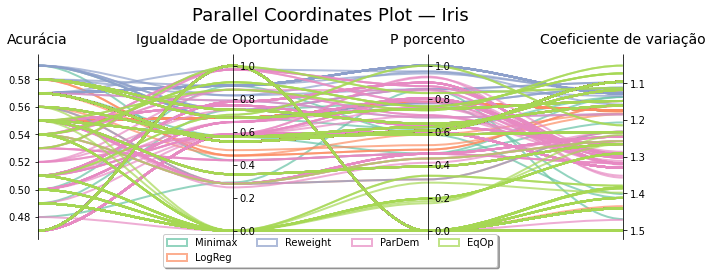

In [104]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
from sklearn import datasets

target_names = ['Minimax','LogReg','Reweight','ParDem','EqOp']
target = metrics_all["model_id"].to_numpy()
ynames = ['Acurácia','Igualdade de Oportunidade','P porcento','Coeficiente de variação']
ys = metrics_all[['Acurácia','Igualdade de Oportunidade','P porcento','Coeficiente de variação']].to_numpy()
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05

ymaxs[3], ymins[3] = ymins[3], ymaxs[3]  # reverse axis 3 to have less crossings
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(10,4))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Parallel Coordinates Plot — Iris', fontsize=18, pad=12)

colors = plt.cm.Set2.colors
legend_handles = [None for _ in target_names]
for j in range(ys.shape[0]):
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[target[j]])
    legend_handles[target[j]] = patch
    host.add_patch(patch)
host.legend(legend_handles, target_names,
            loc='lower center', bbox_to_anchor=(0.5, -0.18),
            ncol=len(ynames), fancybox=True, shadow=True)
plt.tight_layout()
plt.show()